In [121]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

### Load data

In [122]:
df = pd.read_csv("../data/clean/main_df.csv")

In [123]:
# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})
df.drop(['current_year_rank'], axis=1, inplace=True)

def process_categorical(df, col):
    """
    Processes a column of *df* as categorical
    """

    def mapping(df, col):

        new_df = df.copy()

        values = new_df[col].unique()
        mapping = {value: i for i, value in enumerate(values)}
        new_df[col] = new_df[col].map(mapping)

        return new_df

    def one_hot(df, col):
        ext_df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        ext_df.drop([col], axis=1, inplace=True)
        
        return ext_df

    return mapping(df, col)

df = process_categorical(df, "tmID")
# map_strings_to_int(df, "playerID")
# map_strings_to_int(df, "coachID")
# map_strings_to_int(df, "pos")

df.to_csv("../data/clean/pre.csv", index=False)

# print(df['tmID'].to_frame())

### Turn string values into numerical ones

### Training and evaluation function

In [124]:
from dataclasses import dataclass

@dataclass
class Result:
    year: int
    accuracy: float
    auc: float

results = {}

def classification(model, df, min_year, max_year):

    def param_tuning(model, df, min_year, max_year, param_list):
        pass
    
    def test_model(model, df, params):
        pass

    for i in range(min_year, max_year + 1):
        df_train = df[(df['year'] < i) & (df['year'] > 1)]
        df_test = df[df['year'] == i]

        X_train = df_train.drop("playoff", axis=1)  # Features
        y_train = df_train["playoff"]  # Target variable

        X_test = df_test.drop("playoff", axis=1)  # Features
        y_test = df_test["playoff"]  # Target variable

        print(f"\nTrain/Test size for year={i}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        model.fit(X_train, y_train)

        # Predict the response for the test dataset
        y_pred = model.predict(X_test)

        print(f"\nyear = {i}, Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
        print(f"\nyear = {i}, Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(f"\nyear = {i}, AUC: ", roc_auc_score(y_test, y_pred))
        print(f"\nyear = {i}, Accuracy: ", accuracy_score(y_test, y_pred))

        result = Result(
            year=i,
            accuracy=accuracy_score(y_test, y_pred),
            auc=roc_auc_score(y_test, y_pred),
        )

        if (str(model) not in results):
            results[str(model)] = []
        results[str(model)].append(result)

### Define values for min_year and max_year

In [125]:
min_year = 3
max_year = df['year'].max()

### Decision Tree


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       0.50      0.50      0.50         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.50        16
weighted avg       0.50      0.50      0.50        16


year = 3, Confusion Matrix:
 [[4 4]
 [4 4]]

year = 3, AUC:  0.5

year = 3, Accuracy:  0.5

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.57      0.50      0.53         8

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.51      0.50      0.50        14


year = 4, Confusion Matrix:
 [[3 3]
 [4 4]]

year = 4, AUC:  0.5


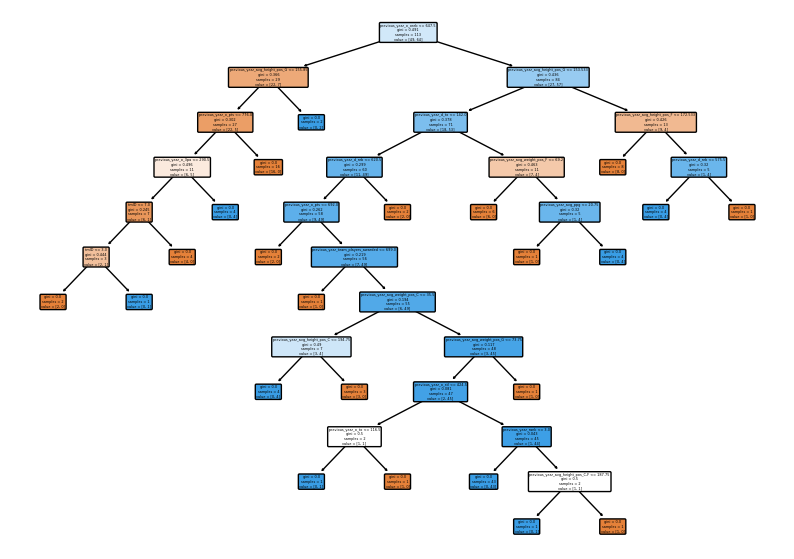

In [126]:
model = DecisionTreeClassifier(random_state=42)
classification(model, df, min_year, max_year)

from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plot_tree(model, filled=True, feature_names=df.columns.to_list(), rounded=True)
plt.show()

### SVM

In [127]:
model = SVC(random_state=42)
classification(model, df, min_year, max_year)


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.67      0.75      0.71         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16


year = 3, Confusion Matrix:
 [[5 3]
 [2 6]]

year = 3, AUC:  0.6875

year = 3, Accuracy:  0.6875

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.62      0.62      0.62         8

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14


year = 4, Confusion Matrix:
 [[3 3]
 [3 5]]

year = 4, AUC:

### Logistic Regression

In [128]:
model = LogisticRegression(random_state=42, solver='newton-cg', max_iter=1000)
classification(model, df, min_year, max_year)
model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)
classification(model, df, min_year, max_year)
model = LogisticRegression(random_state=42, solver='sag', max_iter=1000)
classification(model, df, min_year, max_year)
model = LogisticRegression(random_state=42, solver='saga', max_iter=1000)
classification(model, df, min_year, max_year)
model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
classification(model, df, min_year, max_year)
model = LogisticRegression(random_state=42, solver='newton-cholesky', max_iter=1000)
classification(model, df, min_year, max_year)


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.50      0.62      0.56         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.49        16
weighted avg       0.50      0.50      0.49        16


year = 3, Confusion Matrix:
 [[3 5]
 [3 5]]

year = 3, AUC:  0.5

year = 3, Accuracy:  0.5

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.62      0.62      0.62         8

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14


year = 4, Confusion Matrix:
 [[3 3]
 [3 5]]

year = 4, AUC:  0.56

/usr/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz


year = 5, Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.56      0.62      0.59         8

    accuracy                           0.46        13
   macro avg       0.40      0.41      0.41        13
weighted avg       0.44      0.46      0.45        13


year = 5, Confusion Matrix:
 [[1 4]
 [3 5]]

year = 5, AUC:  0.4125

year = 5, Accuracy:  0.46153846153846156

Train/Test size for year=6: (59, 55) (13, 55) (59,) (13,)

year = 6, Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.75      0.75      0.75         8

    accuracy                           0.69        13
   macro avg       0.68      0.68      0.68        13
weighted avg       0.69      0.69      0.69        13


year = 6, Confusion Matrix:
 [[3 2]
 [2 6]]

year = 6, AUC:  0.675

year = 6, Accuracy:  0.69230769230769

/usr/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz


year = 8, Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       0.50      0.50      0.50         8

    accuracy                           0.38        13
   macro avg       0.35      0.35      0.35        13
weighted avg       0.38      0.38      0.38        13


year = 8, Confusion Matrix:
 [[1 4]
 [4 4]]

year = 8, AUC:  0.35

year = 8, Accuracy:  0.38461538461538464

Train/Test size for year=9: (99, 55) (14, 55) (99,) (14,)

year = 9, Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.71      0.62      0.67         8

    accuracy                           0.64        14
   macro avg       0.64      0.65      0.64        14
weighted avg       0.65      0.64      0.64        14


year = 9, Confusion Matrix:
 [[4 2]
 [3 5]]

year = 9, AUC:  0.6458333333333334

year = 9, Accuracy:  0.642

/usr/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  war


year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.55      0.75      0.63         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16


year = 3, Confusion Matrix:
 [[3 5]
 [2 6]]

year = 3, AUC:  0.5625

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.70      0.88      0.78         8

    accuracy                           0.71        14
   macro avg       0.72      0.69      0.69        14
weighted avg       0.72      0.71      0.70        14


year = 4, Confusion Matrix:
 [[3 3]
 [1 7]]

year = 4, AUC:  0.6875

year = 4, Accuracy:  0.7142857142857143

Train/Te

/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w


year = 9, Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.17      0.18         6
           1       0.44      0.50      0.47         8

    accuracy                           0.36        14
   macro avg       0.32      0.33      0.33        14
weighted avg       0.34      0.36      0.35        14


year = 9, Confusion Matrix:
 [[1 5]
 [4 4]]

year = 9, AUC:  0.3333333333333333

year = 9, Accuracy:  0.35714285714285715

Train/Test size for year=10: (113, 55) (13, 55) (113,) (13,)

year = 10, Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.75      0.75      0.75         8

    accuracy                           0.69        13
   macro avg       0.68      0.68      0.68        13
weighted avg       0.69      0.69      0.69        13


year = 10, Confusion Matrix:
 [[3 2]
 [2 6]]

year = 10, AUC:  0.675

year = 10, Accuracy

/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



year = 7, Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.86      0.75      0.80         8

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.80      0.79      0.79        14


year = 7, Confusion Matrix:
 [[5 1]
 [2 6]]

year = 7, AUC:  0.7916666666666667

year = 7, Accuracy:  0.7857142857142857

Train/Test size for year=8: (86, 55) (13, 55) (86,) (13,)

year = 8, Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.60      0.75      0.67         8

    accuracy                           0.54        13
   macro avg       0.47      0.47      0.46        13
weighted avg       0.50      0.54      0.51        13


year = 8, Confusion Matrix:
 [[1 4]
 [2 6]]

year = 8, AUC:  0.475

year = 8, Accuracy:  0.538

/usr/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=8.82512e-17): result may not be accurate.
  warnings.warn(


### Random Forest

In [129]:
model = RandomForestClassifier(random_state=42)
classification(model, df, min_year, max_year)


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.62      0.62      0.62         8

    accuracy                           0.62        16
   macro avg       0.62      0.62      0.62        16
weighted avg       0.62      0.62      0.62        16


year = 3, Confusion Matrix:
 [[5 3]
 [3 5]]

year = 3, AUC:  0.625

year = 3, Accuracy:  0.625

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.62      0.62      0.62         8

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14


year = 4, Confusion Matrix:
 [[3 3]
 [3 5]]

year = 4, AUC:  

### Gradient Boosting Classifier

In [130]:
model = GradientBoostingClassifier()
classification(model, df, min_year, max_year)


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.43      0.38      0.40         8

    accuracy                           0.44        16
   macro avg       0.44      0.44      0.44        16
weighted avg       0.44      0.44      0.44        16


year = 3, Confusion Matrix:
 [[4 4]
 [5 3]]

year = 3, AUC:  0.4375

year = 3, Accuracy:  0.4375

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.50      0.62      0.56         8

    accuracy                           0.43        14
   macro avg       0.38      0.40      0.38        14
weighted avg       0.39      0.43      0.40        14


year = 4, Confusion Matrix:
 [[1 5]
 [3 5]]

year = 4, AUC:

### K Neighbors

In [131]:
model = KNeighborsClassifier()
classification(model, df, min_year, max_year)


Train/Test size for year=3: (16, 55) (16, 55) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.43      0.38      0.40         8

    accuracy                           0.44        16
   macro avg       0.44      0.44      0.44        16
weighted avg       0.44      0.44      0.44        16


year = 3, Confusion Matrix:
 [[4 4]
 [5 3]]

year = 3, AUC:  0.4375

year = 3, Accuracy:  0.4375

Train/Test size for year=4: (32, 55) (14, 55) (32,) (14,)



year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.62      0.62      0.62         8

    accuracy                           0.57        14
   macro avg       0.56      0.56      0.56        14
weighted avg       0.57      0.57      0.57        14


year = 4, Confusion Matrix:
 [[3 3]
 [3 5]]

year = 4, AUC:  0.5625

year = 4, Accuracy:  0.5714285714285714

Train/Test size for year=5: (46, 55) (13, 55) (46,) (13,)

year = 5, Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13


year = 5, Confusion Matrix:
 [[3 2]
 [1 7]]

year = 5, AUC:  0.7375

year = 5, Accuracy:  0.76923076923076

# Results

In [132]:
from pprint import pprint

# Extracting accuracy for the last year for each model
previous_year_accuracies = {model: results[model][-1].accuracy for model in results}

# Sorting the results by accuracy in descending order
sorted_results = dict(sorted(previous_year_accuracies.items(), key=lambda item: item[1], reverse=True))

# Printing the results
print("Train/test results for the last year of data:\n")
for model, accuracy in sorted_results.items():
    print(f"{model}: {accuracy:.4f}")

for model in results:
    for result in results[model]:
        if result.accuracy == 1:
            print(f"\n{model} has 100% accuracy for year {result.year}, possible data leakage")

Train/test results for the last year of data:

LogisticRegression(max_iter=1000, random_state=42, solver='sag'): 0.6923
SVC(random_state=42): 0.6154
LogisticRegression(max_iter=1000, random_state=42): 0.6154
LogisticRegression(max_iter=1000, random_state=42, solver='saga'): 0.6154
KNeighborsClassifier(): 0.6154
DecisionTreeClassifier(random_state=42): 0.5385
RandomForestClassifier(random_state=42): 0.5385
LogisticRegression(max_iter=1000, random_state=42, solver='newton-cg'): 0.4615
LogisticRegression(max_iter=1000, random_state=42, solver='newton-cholesky'): 0.4615
GradientBoostingClassifier(): 0.4615
LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'): 0.3846
